In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tqdm import tqdm
import pickle
import tensorflow as tf
from data import preprocess 
import os
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import load_model

captions_path = '.\\datasets\\captions.csv'
img_dir_path = '.\\datasets\\images'
start_tkn = "starttkn"
end_tkn = "endtkn"

colab_path = "./colab"

In [2]:
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [3]:
def encodeImage(img, output_dim):
  # Resize all images to a standard size (specified bythe image encoding network)
  #img = img.resize((width, height), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tf.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  #print(x.shape)
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, output_dim)
  return x

In [4]:
embedding_dim = 256
max_len = 74
max_words = 5001


In [5]:
cap_model_path = os.path.join(colab_path, "cap_model.h5")    

In [6]:
model = load_model(cap_model_path)

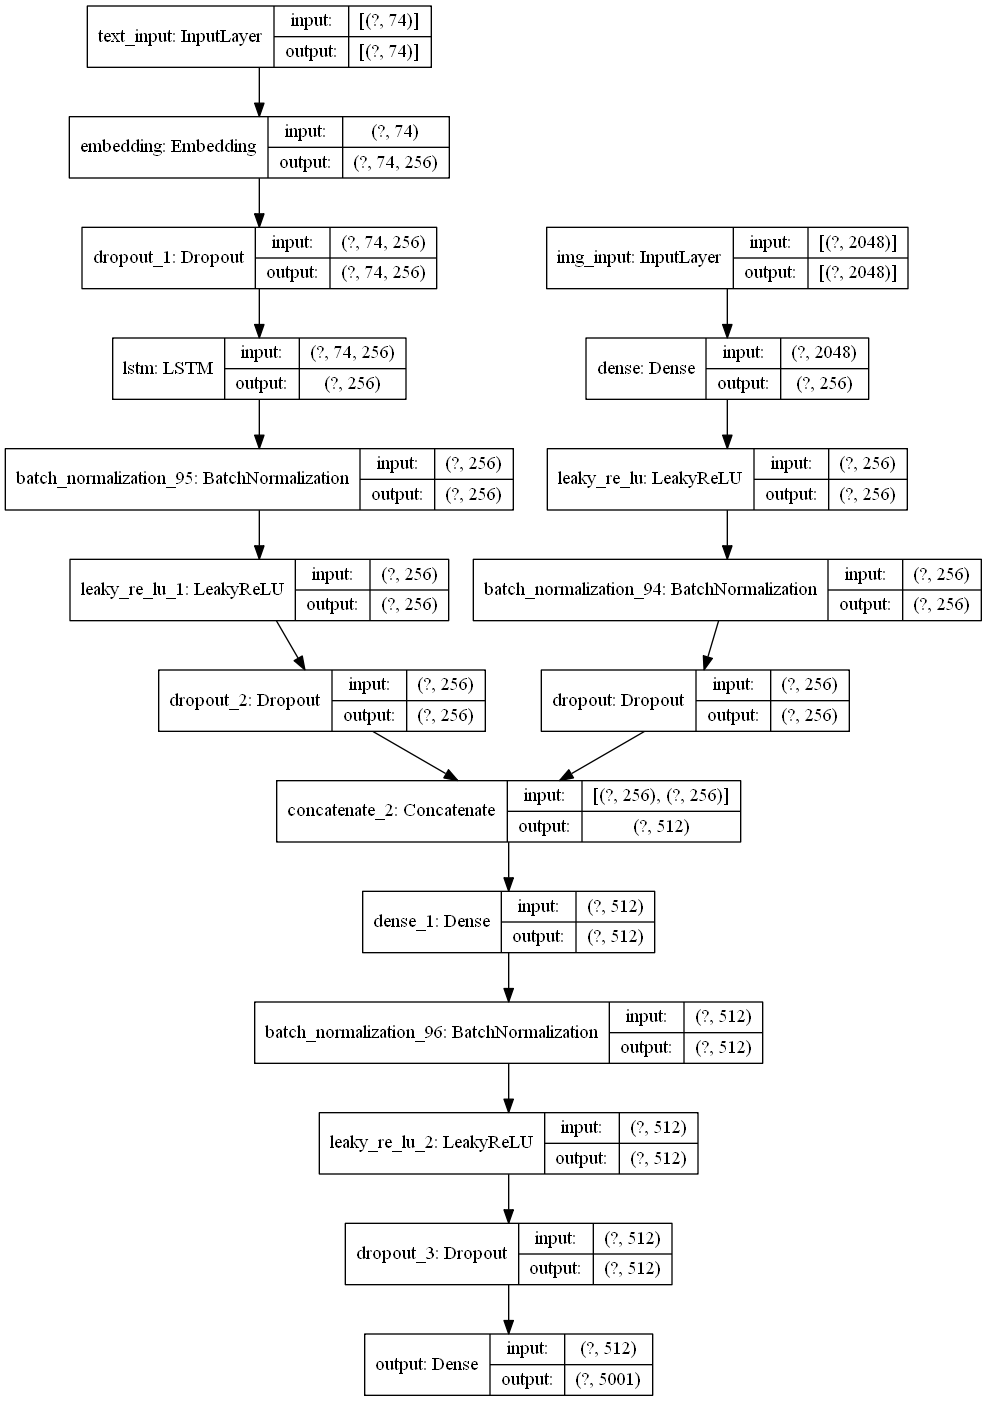

In [7]:
from IPython.display import SVG
import tensorflow as tf

%matplotlib inline
#pydot.
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [8]:

#print(__file__)
image_list = []
encoding_train_dict = {}
tokenizer = []
cap_model = None
image_list_path = os.path.join(colab_path, "image_list.pkl")
with open(image_list_path, "rb") as fp:
    image_list = pickle.load(fp)
image_list

encoding_train_dict_path =  os.path.join(colab_path, "encoding_train_dict.pkl")
with open(encoding_train_dict_path, "rb") as fp:
    encoding_train_dict = pickle.load(fp)
    
tokenizer_path =  os.path.join(colab_path, "tokenizer.pkl")
with open(tokenizer_path, "rb") as fp:
    tokenizer = pickle.load(fp)

test_img_list = []
test_img_list_path = os.path.join(colab_path, "test_img_list.pkl")
with open(test_img_list_path, "rb") as fp:
    test_img_list = pickle.load(fp)

In [9]:
tokenizer.index_word[0] = ''
tokenizer.word_index[''] = 0
START = "starttkn"
STOP = "endtkn"
idxtoword = tokenizer.index_word
wordtoidx = tokenizer.word_index

In [10]:
def generateCaption(photo):
    in_text = START
    for i in range(max_len):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = preprocessing.sequence.pad_sequences([sequence], maxlen=max_len)
        #print(tokenizer.sequences_to_texts(sequence))
        #print(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        #print(yhat)
        word = idxtoword[yhat]
        #print('predict word : ', word)
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

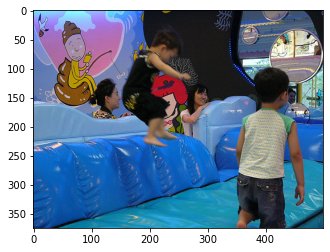

two children are playing in the water


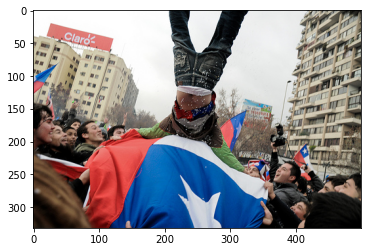

man in red shirt is holding up the air


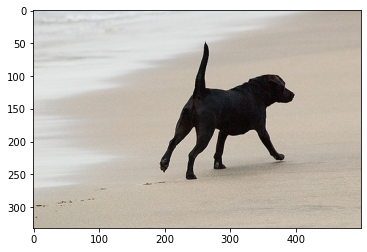

black dog is running through the sand


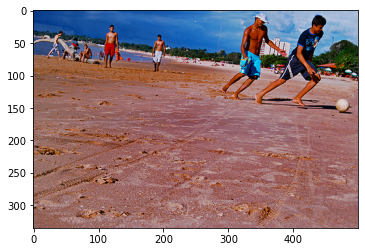

man in blue shirt is playing the beach


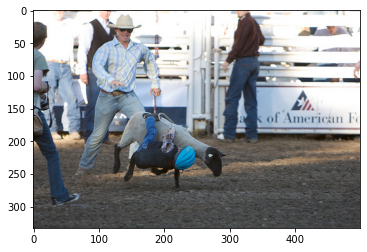

man in blue shirt is standing on the sidewalk


In [11]:
for idx in np.random.choice(len(test_img_list), 5):
    img_path = test_img_list[idx]
    #print(img_path)
    plt.imshow(Image.open(img_path))
    plt.show()
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
    #print(type(img))
    img = encodeImage(img, OUTPUT_DIM).reshape(1, -1)
    #print(len(img))
    predict  = generateCaption(img)
    print(predict)

In [16]:
def show_result(img_path):
    img_path = img_path
    plt.imshow(Image.open(img_path))
    plt.show()
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(HEIGHT, WIDTH))
    #print(type(img))
    img = encodeImage(img, OUTPUT_DIM).reshape(1, -1)
    #print(len(img))
    predict  = generateCaption(img)
    print(predict)

In [23]:
import glob
show_img_list = glob.glob("./predict_set/*.*")
show_img_list
# https://unsplash.com/

['./predict_set\\photo-1586320902477-24c19029bd4a.jfif',
 './predict_set\\photo-1586338445751-05dce666cc3d.jfif']

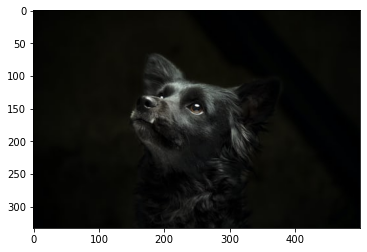

black dog is running through the water


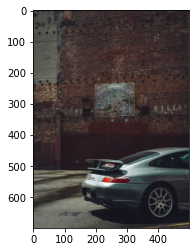

man is standing on car with car in the background


In [24]:
for img_path in show_img_list:
    show_result(img_path)